---
title: Does it really rain a lot in Seattle?
date: 2020-05-02
draft: true

---

# Project motivation

When people speak about places to live and visit, a few things come to mind almost immediately: culture, food, and __weather__. While I was looking to relocate to Seattle, my friends almost universally responded "it rains a lot there." Seattle might as well be a synonym for rain. I have lived in Chicago for  several years. The Midwest has its grey, rainy days, so I was not deterred by these comments. While I won't be comparing Chicago to Seattle in this post, I will generally explore the rain patterns of Seattle to find out if the anecdotes are true.

A few questions come to mind as it pertains to weather in Seattle:

- What frequency does it rain?
- How much actual rainfall occurs (measured in precipitation/inches)?
- Are there seasonal trends of rain?
- Can we predict whether it will rain on a given day with the available data?

While I won't include national data in this exploration, I will try to compare Seattle results to national averages.

In [1]:
import numpy as np
import pandas as pd
import collections
import random
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import seaborn as sns
from tabulate import tabulate
%matplotlib inline

dpi_value = 125

## Gather data

In [2]:
weather_df = pd.read_csv("seattleWeather_1948-2017.csv", parse_dates=True, squeeze=True)
weather_df.columns = map(str.lower, weather_df.columns)

The [data](https://www.kaggle.com/rtatman/did-it-rain-in-seattle-19482017) we will use for this analysis is a time series from 1948-2017 with the following:

- `date`: date associated with weather metrics
- `prcp`: percipitation in inches
- `tmax`: max temperature (Fahrenheit)
- `tmin`: minimum temperature (Fahrenheit)
- `rain`: whether it rained or not

## Assess

In [3]:
weather_df.head()

,date,prcp,tmax,tmin,rain
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [4]:
weather_df.shape

(25551, 5)

In [5]:
weather_df.dtypes

date     object
prcp    float64
tmax      int64
tmin      int64
rain     object
dtype: object

In [6]:
weather_df.describe()

,prcp,tmax,tmin
count,25548.000000,25551.000000,25551.000000
mean,0.106222,59.544206,44.514226
std,0.239031,12.772984,8.892836
min,0.000000,4.000000,0.000000
25%,0.000000,50.000000,38.000000
50%,0.000000,58.000000,45.000000
75%,0.100000,69.000000,52.000000
max,5.020000,103.000000,71.000000


## Clean
We will convert the date column to a datetime object so we can perform analysis with respect to time. Additionally, we will add some features of dates for later use.

In [7]:
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df['day'] = [d.day for d in weather_df.date]
weather_df['month'] = [d.month for d in weather_df.date]
weather_df['year'] = [d.year for d in weather_df.date]
weather_df = weather_df[['date', 'year', 'month', 'day', 'prcp', 'tmax', 'tmin', 'rain']]
weather_df.head()

,date,year,month,day,prcp,tmax,tmin,rain
0,1948-01-01,1948,1,1,0.47,51,42,True
1,1948-01-02,1948,1,2,0.59,45,36,True
2,1948-01-03,1948,1,3,0.42,45,35,True
3,1948-01-04,1948,1,4,0.31,45,34,True
4,1948-01-05,1948,1,5,0.17,45,32,True


Missing values do not look significant since we have 25,551 rows and only three rows are missing in the `prcp` and `rain` column. We will leave these missing values alone for now until they pose a problem.

In [8]:
weather_df[weather_df.prcp.isnull()]

,date,year,month,day,prcp,tmax,tmin,rain
18415,1998-06-02,1998,6,2,NaN,72,52,NaN
18416,1998-06-03,1998,6,3,NaN,66,51,NaN
21067,2005-09-05,2005,9,5,NaN,70,52,NaN


## Visualize
Here are general time series plots of the numeric data. We will focus on the last few years to make it easier to notice any patterns. There is some seasonality in precipitation and temperature, which is typically common knowledge in weather and climate. However, sometimes seasonality is not obvious depending on the region.

In [9]:
def visualize(data, title, xlabel, ylabel,
              percent_y_ticks=False, legend_values=None,
              mean_value=None, mean_line_color=None,
              plot_type='pandas', seaborn_plot_type=None, 
              seaborn_legend=None, save_plot=False, 
              save_path=None, dpi=None, **kwargs):
    '''
    Wrapper plot function around pandas plots and seaborn to visualize data and save results.
    
    :param data: :param data: a pandas dataframe used for plotting
    :param title: string title of plot
    :param xlabel: string label for x-axis
    :param ylabel: string label for y-axis
    :param percent_y_ticks: boolean for percent format
    :param legend_values: list of strings used for changing label of legend
    :param mean_value: float mean value used to plot
    :param mean_line_color: string color of mean value line
    :param plot_type: string with two possible values of pandas or seaborn
    :param seaborn_plot_type: string specifying seaborn plot type
    :param seaborn_legend: string to control legend values, only "all" to keep entire legend
    :param save_plot: boolean specifying to save plot
    :param save_path: string name of plot for saving
    :param dpi: int used for resolution
    :param kwargs: remaining arguments passed to pandas/seaborn plot functions
    
    :return: a plot
    '''
    if plot_type == 'pandas':
        plot = data.plot(**kwargs)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if mean_value is not None:
            plt.axhline(y=mean_value, xmin=-1, xmax=1, color=mean_line_color, linestyle='--', lw=2)
        if percent_y_ticks:
            vals = plot.get_yticks()
            plot.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
        if legend_values is not None:
            plt.legend(legend_values)
        if save_plot:
            fig = plot.get_figure()
            fig.savefig(save_path, dpi=dpi_value)
        
    if plot_type == 'seaborn':

        seaborn_type_dict = {
            'scatter': sns.scatterplot,
            'swarm': sns.swarmplot
        }

        plot = seaborn_type_dict[seaborn_plot_type](**kwargs, data=data)
        plot.set(title=title,
                 xlabel=xlabel,
                 ylabel=ylabel)
        if seaborn_legend == 'all':
                handles, labels = plot.get_legend_handles_labels()
                plot.legend(handles=handles, labels=labels)
        else:
            handles, labels = plot.get_legend_handles_labels()
            plot.legend(handles=handles[1:], labels=labels[1:])
        if save_plot:
            fig = plot.get_figure()
            fig.savefig(save_path, dpi=dpi_value)
    return plot

In [10]:
washington_colors = ['#37835a', '#5ec1db']

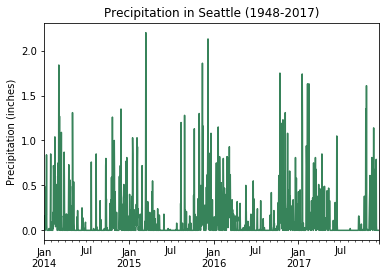

In [11]:
plot_data = weather_df[weather_df['year'] >= 2014]
visualize(plot_data,
          title='Precipitation in Seattle (1948-2017)',
          xlabel=None,
          ylabel='Precipitation (inches)',
          legend_values=None,
          plot_type='pandas',
          save_plot=True,
          save_path='output.png',
          dpi=dpi_value,
          x='date',
          y='prcp',
          color=washington_colors[0],
          legend=False);

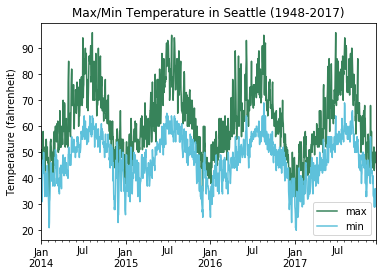

In [12]:
visualize(plot_data,
          title='Max/Min Temperature in Seattle (1948-2017)',
          xlabel=None,
          ylabel='Temperature (fahrenheit)',
          legend_values=['max', 'min'],
          plot_type='pandas',
          save_plot=True,
          save_path='output2.png',
          dpi=dpi_value,
          x='date',
          y=['tmax', 'tmin'],
          color=washington_colors,
          legend=False);

## Analyze
### 1) What frequency does it rain in Seattle?

In [13]:
proportion_df = pd.DataFrame(weather_df['rain'].value_counts() / weather_df.shape[0]).reset_index()
proportion_df = proportion_df.rename(columns={'index': 'rain', 'rain': 'proportion'})
proportion_df['rain'] = np.where(proportion_df['rain'], 'Rain', 'No rain')

It rained 43% of the time in Seattle from 1948-2017. On average, that's approximately 157 days per year.

In [14]:
proportion_df

,rain,proportion
0,No rain,0.573285
1,Rain,0.426598


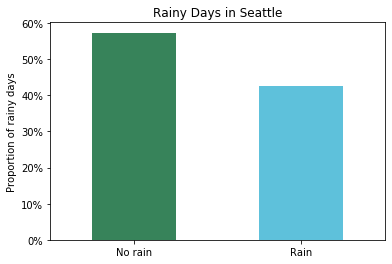

In [15]:
visualize(proportion_df,
          title='Rainy Days in Seattle',
          xlabel=None,
          ylabel='Proportion of rainy days',
          legend_values=None,
          plot_type='pandas',
          save_plot=True,
          save_path='output3.png',
          dpi=dpi_value,
          x='rain', 
          y='proportion',
          percent_y_ticks=True,
          kind='bar',
          rot=0,
          color=washington_colors,
          legend=False);

How does this compare to the rest of the U.S.?

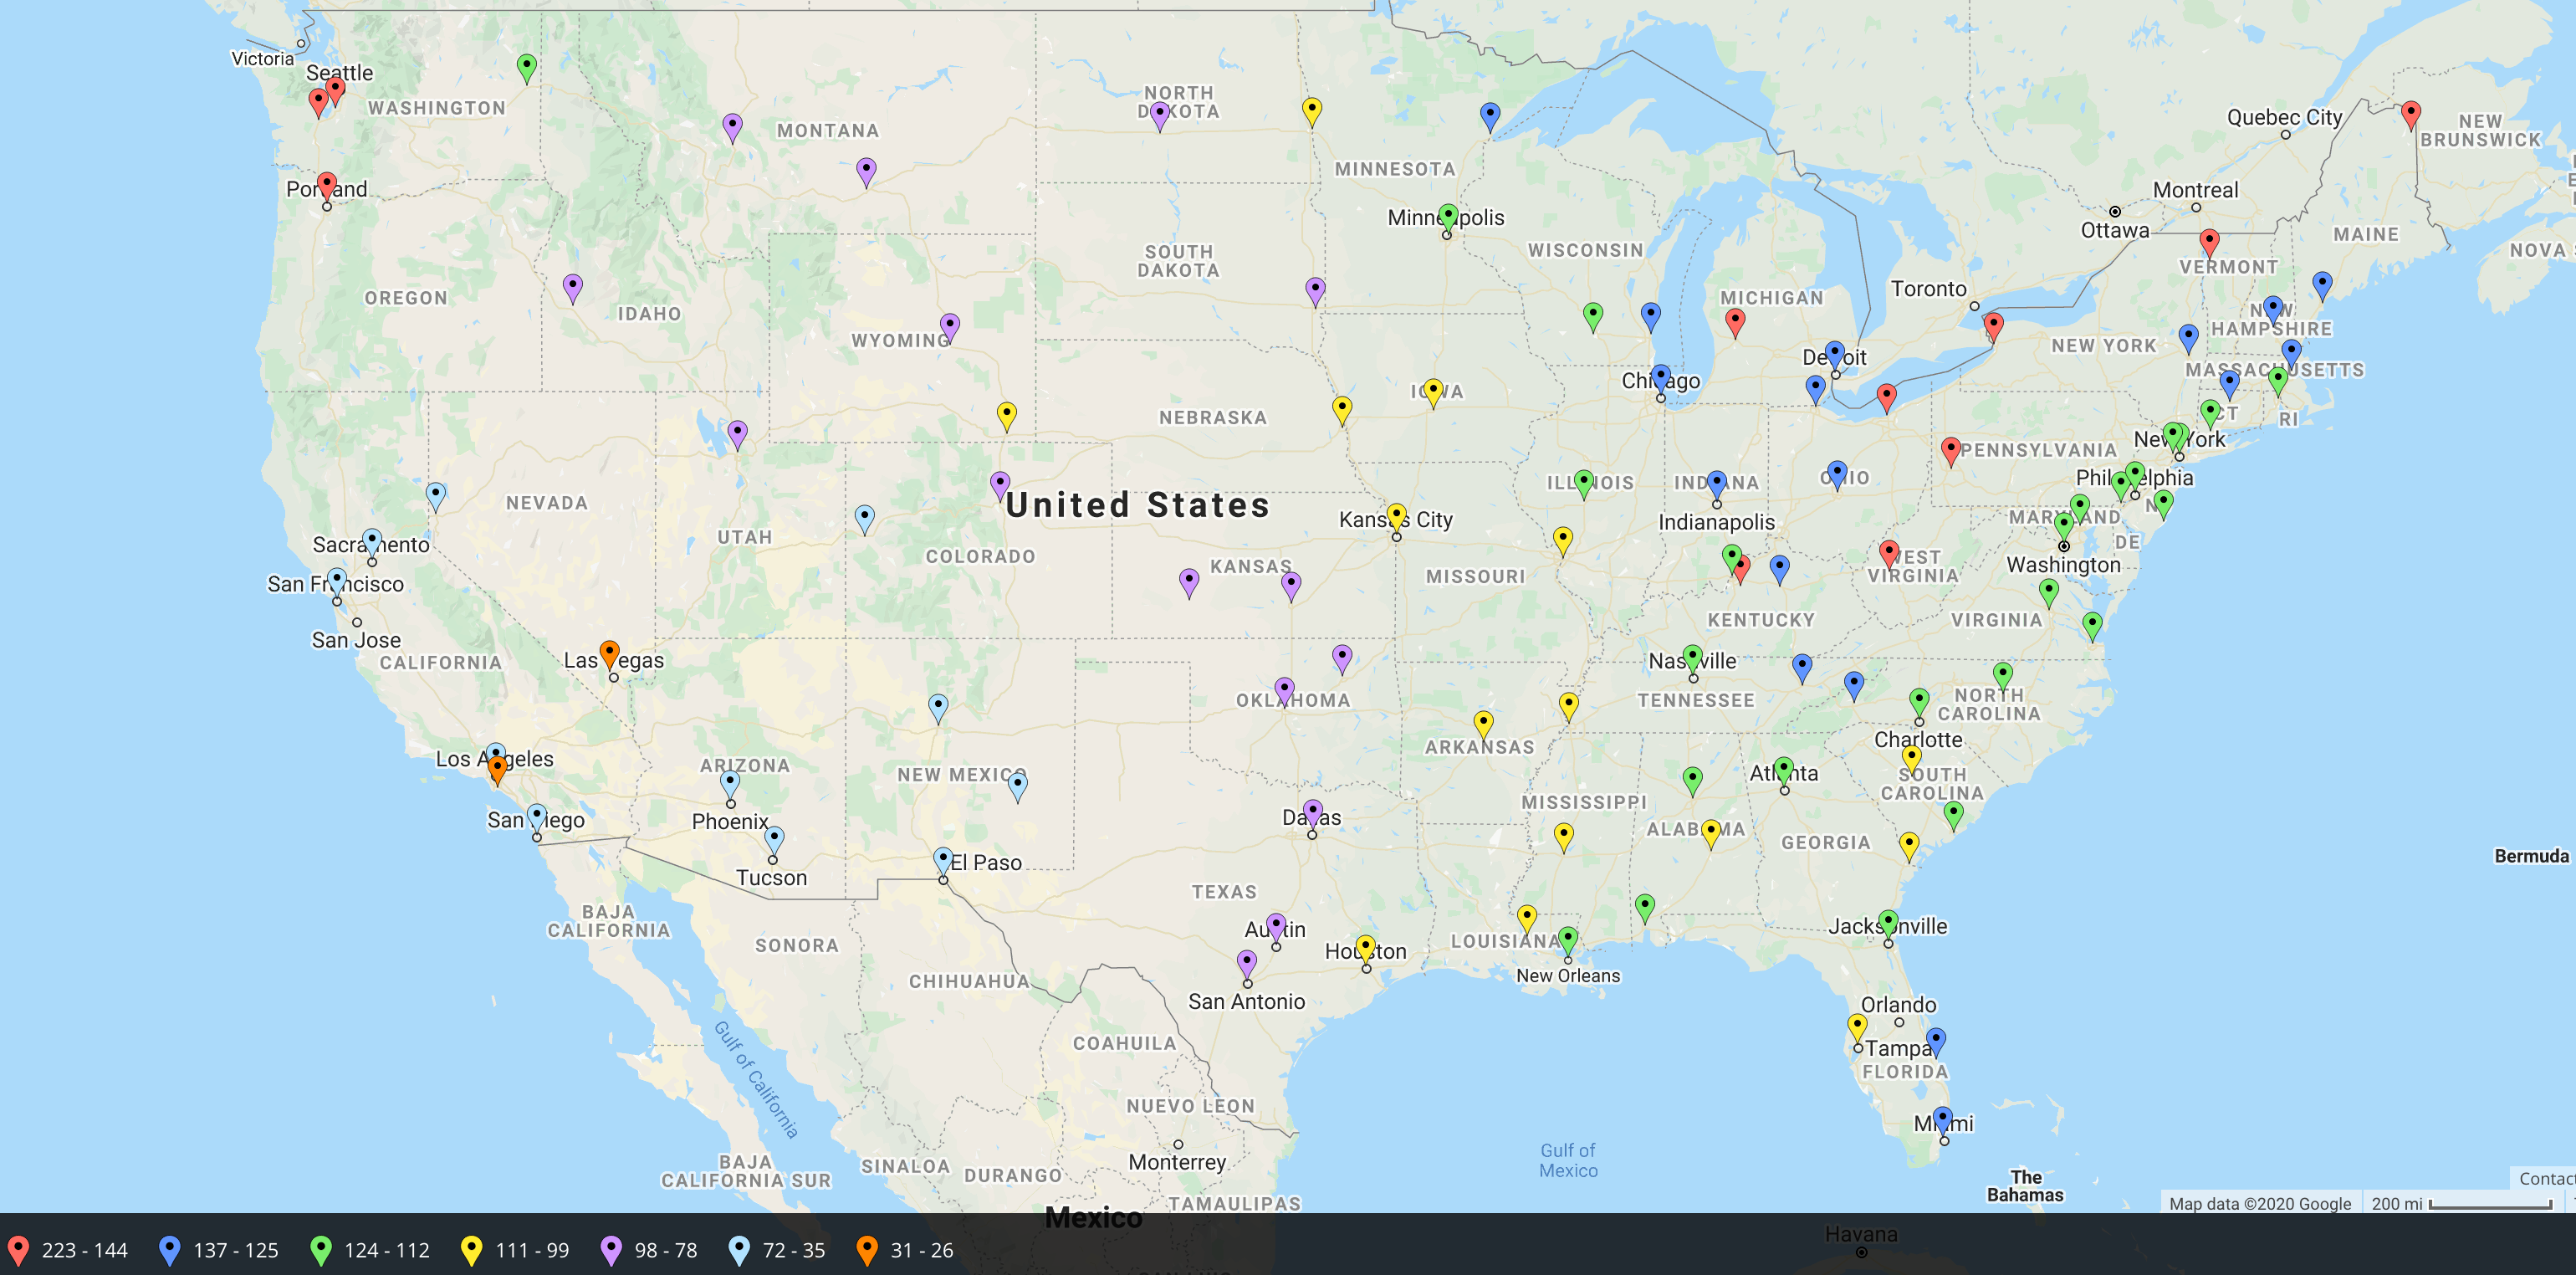

In [16]:
from IPython.display import Image
Image('national_rainfall.png')

Washington is red, indicating that the state experiences rain 144-223 days over the course of the year. Our analysis shows about 153 days of rain each year from 1948-2017. There are a few other states/areas in the northeast that experience similar levels to Seattle in terms of rain. Most of the states center between 78-137 days of rain each year.

#### Rain frequency by year
The previous plot is an average of the data from 1948-2017. I am curious if the proportion of rainy days significantly vary across time.

In [17]:
rain_by_year_df = weather_df[['year', 'rain']].groupby(['year', 'rain']).size().unstack(fill_value=0).reset_index()
rain_by_year_df = rain_by_year_df.assign(total=rain_by_year_df[False] + rain_by_year_df[True])
rain_by_year_df = rain_by_year_df.assign(rain_proportion = rain_by_year_df[True] / rain_by_year_df.total).drop([False, True, 'total'], axis=1).set_index('year')
rain_by_year_mean = rain_by_year_df.rain_proportion.mean()
rain_by_year_df.head()

rain,rain_proportion
year,
1948,0.483607
1949,0.380822
1950,0.531507
1951,0.410959
1952,0.379781


At first glance, the data looks [mean-reverting](https://mathworld.wolfram.com/ReversiontotheMean.html). There is a strong decline in rainy days starting in the mid 1970s that oscillates until the 1990s, but this is probably more random than any kind of trend.

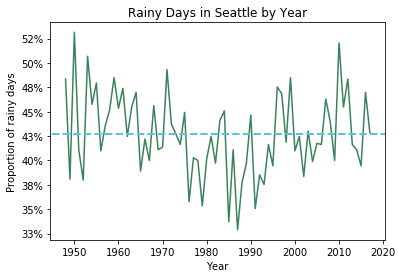

In [18]:
visualize(rain_by_year_df,
          title='Rainy Days in Seattle by Year',
          xlabel='Year',
          ylabel='Proportion of rainy days',
          legend_values=None,
          mean_value=rain_by_year_mean,
          mean_line_color=washington_colors[1],
          plot_type='pandas',
          save_plot=True,
          save_path='output4.png',
          dpi=dpi_value,
          percent_y_ticks=True,
          kind='line',
          rot=0,
          color=washington_colors[0],
          legend=False);

#### Rain frequency by month
Before we look at frequency of rainy days by month, what would we expect? I have spent a lot of time in Florida and we typically expect rain during the summer through the fall (hurricane season). Does Seattle follow similar trends for when rain? Probably not, given Florida is tropical and Seattle is tucked away in a mountainous region. But I am not a weather or geological expert. Let's look at the data.

In [19]:
# create months_dict to convert month numbers to strings
def convert_month(month):
    '''
    Convert numeric month value to string representation
    
    :param month: int value representing month
    
    :return: month string representation
    '''

    months_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 
                   4: 'Apr', 5: 'May', 6: 'Jun',
                   7: 'Jul', 8: 'Aug', 9: 'Sep',
                   10: 'Oct', 11: 'Nov', 12: 'Dec'}
    
    return months_dict[month]

In [20]:
rain_by_month_prop = weather_df[['month', 'rain']].groupby(['month', 'rain']).size().unstack(fill_value=0).reset_index()
rain_by_month_prop = rain_by_month_prop.assign(total = rain_by_month_prop[False] + rain_by_month_prop[True])
rain_by_month_prop = rain_by_month_prop.assign(rain_proportion = rain_by_month_prop[True] / rain_by_month_prop.total)
rain_by_month_prop = rain_by_month_prop.drop([True, False, 'total'], axis=1)
rain_by_month_prop.set_index(rain_by_month_prop.month.apply(convert_month), inplace=True)
rain_by_month_prop.drop('month', axis=1, inplace=True)

Interestingly, rainy days in the summer is not the case in Seattle. On the contrary, it looks like the least amount of rainy days happen during the summer and fall! The peak amount of rainy days occur during the winter. Something to look further into would be the amount of rain/precipitation in each season. It's possible that there are not as many rainy days in the summer, but when it rains, there is more volume of rain compared to the winter.

In [21]:
rain_by_month_prop

rain,rain_proportion
month,
Jan,0.598157
Feb,0.557634
Mar,0.558525
Apr,0.475238
May,0.355300
Jun,0.301239
Jul,0.158065
Aug,0.190323
Sep,0.290138


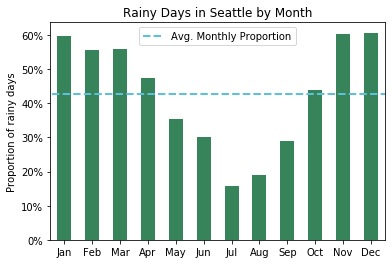

In [22]:
visualize(rain_by_month_prop,
          title='Rainy Days in Seattle by Month',
          xlabel=None,
          ylabel='Proportion of rainy days',
          legend_values=['Avg. Monthly Proportion'],  
          mean_value=rain_by_month_prop.rain_proportion.mean(),
          mean_line_color=washington_colors[1],
          plot_type='pandas',
          save_plot=True,
          save_path='output5.png',
          dpi=dpi_value,
          percent_y_ticks=True,
          kind='bar',
          rot=0,
          color=washington_colors[0],
          legend=False);

### 2) How much rainfall occurs in Seattle?
We learned that rainy days (categorized as any amount of rain occurring in a day), is least likely during the summer in Seattle. In this section, we will look further to explore the trends in actual rainfall over years and months.

In [23]:
monthly_mean = weather_df[['month', 'prcp', 'tmax', 'tmin']].groupby(['month']).mean().reset_index()
monthly_mean.set_index(monthly_mean.month.apply(convert_month), inplace=True)
monthly_mean.drop('month', axis=1, inplace=True)
monthly_mean

,prcp,tmax,tmin
month,,,
Jan,0.183055,45.131797,35.208756
Feb,0.143023,48.994944,36.787664
Mar,0.127963,52.321659,38.393548
Apr,0.088505,57.521905,41.460952
May,0.058502,64.309217,46.733180
Jun,0.048522,69.653333,51.628571
Jul,0.023106,75.497696,55.005530
Aug,0.034968,75.233180,55.317512
Sep,0.059057,69.631905,51.754286


We see a similar U-shape in mean precipitation compared to the rainy days plot. In other words, more actual rain fall occurs in the winter with the least amount of rainfall occurring in the summer. Let's see if temperature provides any additional information.

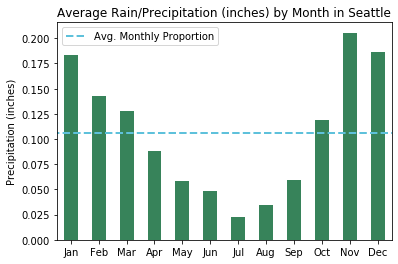

In [24]:
visualize(monthly_mean[['prcp']],
          title='Average Rain/Precipitation (inches) by Month in Seattle',
          xlabel=None,
          ylabel='Precipitation (inches)',
          legend_values=['Avg. Monthly Proportion'],  
          mean_value=monthly_mean.prcp.mean(),
          mean_line_color=washington_colors[1],
          plot_type='pandas',
          save_plot=True,
          save_path='output6.png',
          dpi=dpi_value,
          kind='bar',
          rot=0,
          color=washington_colors[0],
          legend=False);

Higher temperatures in the summer coincide with less rain. Normally I think of higher temperatures with humidity and rain, but this is not the case in Seattle. Next we will look at temperature ranges in each month.

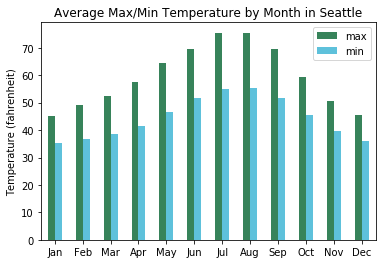

In [25]:
visualize(monthly_mean[['tmax', 'tmin']],
          title='Average Max/Min Temperature by Month in Seattle',
          xlabel=None,
          ylabel='Temperature (fahrenheit)',
          legend_values=['max', 'min'],  
          plot_type='pandas',
          save_plot=True,
          save_path='output7.png',
          dpi=dpi_value,
          kind='bar',
          rot=0,
          color=washington_colors,
          legend=False);

In [26]:
temp_ranges = monthly_mean.tmax - monthly_mean.tmin
temp_ranges.index = monthly_mean.index

Seattle's winter has the most stable temperatures, while the summer has a wide gap between high/low temperatures.

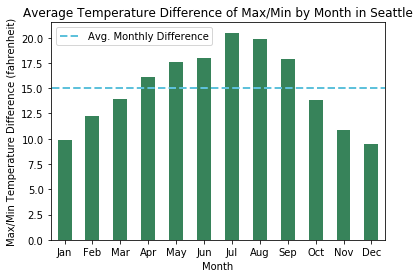

In [27]:
plot_data = monthly_mean[['tmax', 'tmin']].assign(max_min_gap = temp_ranges)['max_min_gap']

visualize(plot_data,
          title='Average Temperature Difference of Max/Min by Month in Seattle',
          xlabel='Month',
          ylabel='Max/Min Temperature Difference (fahrenheit)',
          mean_value=temp_ranges.mean(),
          mean_line_color=washington_colors[1],          
          legend_values=['Avg. Monthly Difference'],  
          plot_type='pandas',
          save_plot=True,
          save_path='output8.png',
          dpi=dpi_value,
          kind='bar',
          rot=0,
          color=washington_colors[0],
          legend=False);

### 3) Are there seasonal trends of rain in Seattle?
We answered this question in our exploration. Rain is persistent in the winter, while the summer appears to experience the least amount of rain. A quick [web search](https://cliffmass.blogspot.com/2015/02/why-is-northwest-warm-and-california.html) reveals that Seattle summers are warm and dry for specific meteorological reasons that we won't get into.

### 4) Can we predict Seattle Rain?
Can we predict whether it will rain on a given day in Seattle? Through our exploration, we noticed that rainy days are related to the time of year and temperature. But our exploration did not look at lag features. We will explore some simple lag features and use them to solve the binary classification problem: rain or no rain on a given day in Seattle.

Here is a brief view of our lag features:

In [28]:
weather_lag_df = weather_df.assign(tmin_lag1 = weather_df.tmin.shift(1),
                                   tmin_lag2 = weather_df.tmin.shift(2),
                                   tmin_lag3 = weather_df.tmin.shift(3),
                                   tmax_lag1 = weather_df.tmax.shift(1),
                                   tmax_lag2 = weather_df.tmax.shift(2),
                                   tmax_lag3 = weather_df.tmax.shift(3),
                                   prcp_lag1 = weather_df.prcp.shift(1),
                                   prcp_lag2 = weather_df.prcp.shift(2),
                                   prcp_lag3 = weather_df.prcp.shift(3))

In [29]:
weather_lag_df = weather_lag_df.dropna().drop(['prcp', 'tmax', 'tmin'], axis=1)
weather_lag_df.head()

,date,year,month,day,rain,tmin_lag1,tmin_lag2,tmin_lag3,tmax_lag1,tmax_lag2,tmax_lag3,prcp_lag1,prcp_lag2,prcp_lag3
3,1948-01-04,1948,1,4,True,35.0,36.0,42.0,45.0,45.0,51.0,0.42,0.59,0.47
4,1948-01-05,1948,1,5,True,34.0,35.0,36.0,45.0,45.0,45.0,0.31,0.42,0.59
5,1948-01-06,1948,1,6,True,32.0,34.0,35.0,45.0,45.0,45.0,0.17,0.31,0.42
6,1948-01-07,1948,1,7,True,39.0,32.0,34.0,48.0,45.0,45.0,0.44,0.17,0.31
7,1948-01-08,1948,1,8,True,40.0,39.0,32.0,50.0,48.0,45.0,0.41,0.44,0.17


#### Feature exploration

In [30]:
plot_data = weather_lag_df.iloc[random.sample(list(weather_lag_df.reset_index().index), 1500), :]
plot_data.loc[:, 'rain'] = np.where(plot_data.loc[:, 'rain'], 'rain', 'no rain')

/Users/joshuagoldberg/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


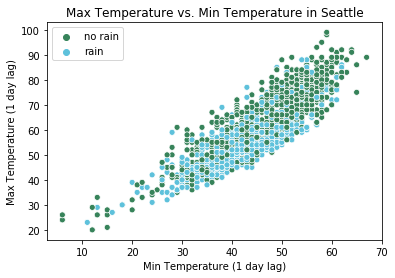

In [31]:
visualize(plot_data,
          title='Max Temperature vs. Min Temperature in Seattle', 
          xlabel='Min Temperature (1 day lag)', 
          ylabel='Max Temperature (1 day lag)',        
          plot_type='seaborn',
          seaborn_plot_type='scatter',
          save_plot=True,
          save_path='output9.png',
          dpi=dpi_value,
          x='tmin_lag1',
          y='tmax_lag1',
          hue='rain',
          palette=washington_colors);

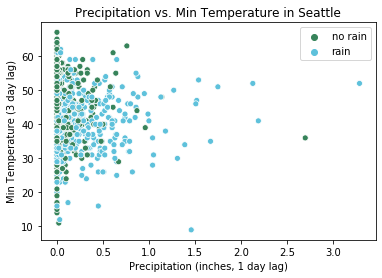

In [32]:
visualize(plot_data,
          title='Precipitation vs. Min Temperature in Seattle', 
          xlabel='Precipitation (inches, 1 day lag)', 
          ylabel='Min Temperature (3 day lag)',        
          plot_type='seaborn',
          seaborn_plot_type='scatter',
          save_plot=True,
          save_path='output10.png',
          dpi=dpi_value,
          x='prcp_lag1',
          y='tmin_lag3',
          hue='rain',
          palette=washington_colors);

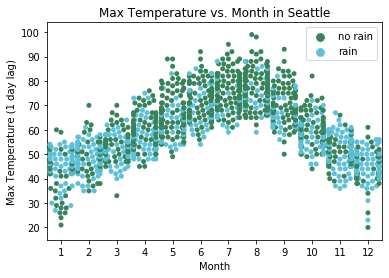

In [33]:
visualize(plot_data,
          title='Max Temperature vs. Month in Seattle', 
          xlabel='Month', 
          ylabel='Max Temperature (1 day lag)',        
          plot_type='seaborn',
          seaborn_plot_type='swarm',
          seaborn_legend='all',
          save_plot=True,
          save_path='output11.png',
          dpi=dpi_value,
          x='month',
          y='tmax_lag1',
          hue='rain',
          palette=washington_colors);

#### Modeling
We will use random forest for this classification problem.

The training data will include everything before the year 1990. All data 1990 and beyond will be used for holdout. We will scale the data to ensure no feature dominates the training process. Lastly, since our data is a dependent time series, we will use an appropriate [splitting method](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html). Note our class frequencies represent approximately what we saw in exploration:

In [34]:
X = weather_lag_df[weather_lag_df['year'] < 1990].drop(['rain', 'year', 'date'], axis=1)
scaler = preprocessing.StandardScaler().fit(X)

X = scaler.transform(X)
y = weather_lag_df[weather_lag_df['year'] < 1990].loc[:, 'rain']
# y = np.where(y, 1, 0)
y = np.where(y, 'rain', 'no rain')
rain_count = collections.Counter(y)
rain_count = pd.DataFrame.from_dict(rain_count, orient='index').reset_index()
rain_count.columns = ['Weather', 'Days Count']
rain_count

,Weather,Days Count
0,rain,6530
1,no rain,8808


We will use data leading up to the year 1990 for training/cross validation. All data 1990 and greater will be used for holdout. Additionally, we will scale the data to ensure no feature dominates the modeling process.

In [35]:
# Split our data for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# create a dictionary of parameters
param_grid = {'n_estimators': [100, 250, 500, 1000], 'max_depth': [3, 5, 10, 15, 20],
              "max_features": [1, 3, 5]}

# create random forest model
rf_obj = RandomForestClassifier()

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Create gridsearch object with various combinations of parameters
rf_grid = GridSearchCV(rf_obj, param_grid, cv=tscv, 
                       scoring=scoring, n_jobs=-1, verbose=0,
                       refit='AUC', return_train_score=True)

In [36]:
%%time
rf_grid.fit(X, y)

CPU times: user 9.83 s, sys: 230 ms, total: 10.1 s
Wall time: 5min 9s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_f...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
     

Now that we have cross validation results, let's check the optimal value for parameters.

In [37]:
results = rf_grid.cv_results_
train_res = pd.DataFrame({'data': 'train', 'auc': results['mean_train_AUC']})
test_res = pd.DataFrame({'data': 'test', 'auc': results['mean_test_AUC']})
max_depth_df = pd.DataFrame({'max_depth': results['param_max_depth']})
n_estimators_df = pd.DataFrame({'n_estimators': results['param_n_estimators']})
max_features_df = pd.DataFrame({'max_features': results['param_max_features']})
plot_model = pd.concat([pd.concat([train_res, test_res], axis=0), 
                        pd.concat([max_depth_df, max_depth_df]),
                        pd.concat([n_estimators_df, n_estimators_df]),
                        pd.concat([max_features_df, max_features_df])], axis=1)
plot_model.head()

,data,auc,max_depth,n_estimators,max_features
0,train,0.755331,3,100,1
1,train,0.756499,3,250,1
2,train,0.755995,3,500,1
3,train,0.756071,3,1000,1
4,train,0.774564,3,100,3


The model quickly begins to overfit with `max_depth` increasing. From sklearn documentation: 
> The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

In other words, an unlimited max depth will allow the tree to grow to the extent that it fits the data perfectly. This is something we want to avoid to achieve a better [generalized](https://en.wikipedia.org/wiki/Generalization_error) result. Fitting data perfectly means we memorize all patterns — signal and noise.

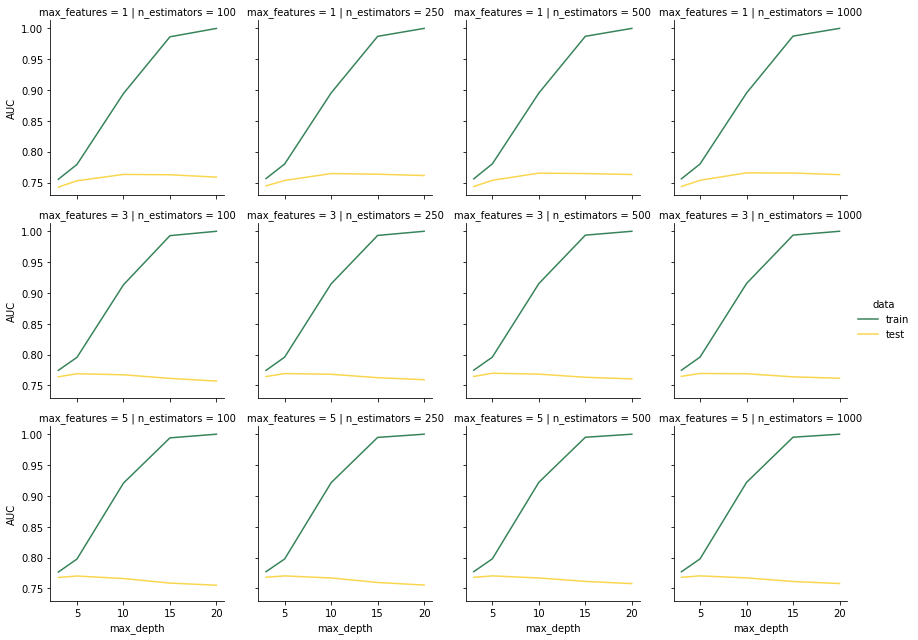

In [38]:
g = sns.FacetGrid(plot_model, col='n_estimators',  row='max_features', hue='data', palette=[washington_colors[0], '#fad64e'])
g.map(plt.plot, 'max_depth', 'auc').add_legend().set_axis_labels('max_depth', 'AUC')
g.savefig('output12.png', dpi=dpi_value)

In [39]:
best_params = rf_grid.best_params_
print(f'Grid search selected the following best parameters based on AUC: max_depth: {best_params["max_depth"]}, max_features: {best_params["max_features"]}, and n_estimators: {best_params["n_estimators"]}.')

Grid search selected the following best parameters based on AUC: max_depth: 5, max_features: 5, and n_estimators: 1000.


In [40]:
rf_best_model = rf_grid.best_estimator_

Let's run our cross validation results with a holdout data set.

In [41]:
X_holdout = weather_lag_df[weather_lag_df['year'] >= 1990].drop(['rain', 'year', 'date'], axis=1)
X_holdout = scaler.transform(X_holdout)
y_holdout = weather_lag_df[weather_lag_df['year'] >= 1990].loc[:, 'rain']
y_holdout = np.where(y_holdout, 1, 0)
rain_count = collections.Counter(y_holdout)
rain_count['No rain'] = rain_count.pop(0)
rain_count['Rain'] = rain_count.pop(1)
rain_count = pd.DataFrame.from_dict(rain_count, orient='index').reset_index()
rain_count.columns = ['Weather', 'Days Count']
rain_count

,Weather,Days Count
0,No rain,5834
1,Rain,4367


In [42]:
from matplotlib.colors import LinearSegmentedColormap

boundaries = [0.0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]  # custom boundaries

# here I generated twice as many colors, 
# so that I could prune the boundaries more clearly
hex_colors = sns.light_palette(washington_colors[0], n_colors=len(boundaries) * 2 + 2, as_cmap=False).as_hex()
hex_colors = [hex_colors[i] for i in range(0, len(hex_colors), 2)]

colors=list(zip(boundaries, hex_colors))

custom_color_map = LinearSegmentedColormap.from_list(
    name='custom_navy',
    colors=colors,
)

The confusion matrix below was constructed using the holdout data (year 1990 and beyond). Our results are decent for a simple model using limited features. We are right about 72% of the time. This compares with the fact that it rains ~43% of the time in Seattle. Our current model is better than the naive decision to predict rain everyday (or no rain everyday).

              precision    recall  f1-score   support

        rain       0.74      0.80      0.77      5834
     no rain       0.70      0.62      0.66      4367

    accuracy                           0.72     10201
   macro avg       0.72      0.71      0.71     10201
weighted avg       0.72      0.72      0.72     10201



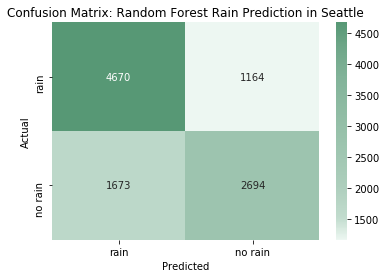

In [43]:
y_test_pred = np.where(rf_best_model.predict(X_holdout) == 'rain', 1, 0)
labels_df = pd.DataFrame({'rain': y_holdout})
labels = labels_df.drop_duplicates(
).sort_values('rain')
labels = labels.assign(label=['rain', 'no rain'])

conf_mat = metrics.confusion_matrix(y_true=y_holdout, y_pred=y_test_pred)
fig, ax = plt.subplots(figsize=(6, 4))
plot = sns.heatmap(conf_mat, annot=True, fmt="d",
                   xticklabels=labels.label.values,
                   yticklabels=labels.label.values, 
                   cmap=custom_color_map)
plot.set(title='Confusion Matrix: Random Forest Rain Prediction in Seattle', 
         xlabel='Predicted',
         ylabel='Actual')
fig = plot.get_figure()
fig.savefig('output13.png', dpi=dpi_value)

print(metrics.classification_report(y_holdout, y_test_pred, target_names=labels.label.values))

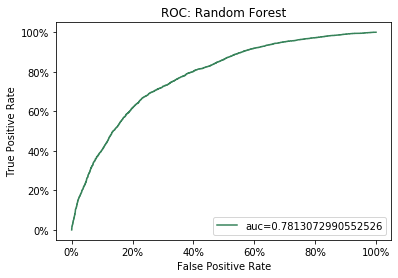

In [44]:
logistic_scores = rf_best_model.predict_proba(X_holdout)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_holdout, logistic_scores)
auc = metrics.roc_auc_score(y_holdout, logistic_scores)
auc_data = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
plot = auc_data.plot(x='fpr', y='tpr', label="auc=" + str(auc), color=washington_colors[0])
vals = plot.get_xticks()
plot.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
vals = plot.get_yticks()
plot.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.title('ROC: Random Forest') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.savefig('output14.png', dpi=dpi_value)
plt.show()

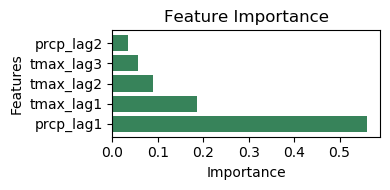

In [45]:
importances = rf_best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking    
headers = ["name", "score"]
values_rf = sorted(zip(weather_lag_df.drop(['rain', 'year', 'date'], axis=1).columns, importances), key=lambda x: x[1] * -1)
# print(tabulate(values_rf[0:10], headers, tablefmt="plain"))

# Plot the feature importances of the forest
plt.rcdefaults()
plt.figure(figsize=[4, 2])
plt.barh(pd.DataFrame(values_rf[0:5]).iloc[:, 0], importances[indices][0:5], align='center', color=washington_colors[0])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('output15.png', dpi=dpi_value)
plt.show()

## What did we learn?

Generally speaking, Seattle experiences a high number of rainy days compared to the rest of the country. However, if we look at actual rainfall, [Seattle ranks](http://www.usa.com/rank/us--average-precipitation--state-rank.htm) in the middle of the pack. 

Anecdotally, Seattle's rain is known to be light and misty. Whether rain is light or heavy, it generally comes with a lack of sunshine. I took this photo on a trip in January a few years ago. The sky was consistently grey. There was rain, but it was light and hardly noticeable.

We also learned that the summers are dry and warm. Seattle summers are [rumored](https://www.thrillist.com/entertainment/seattle/17-reasons-seattle-summers-dominate-all-other-summers) to be a blast — probably driven by the mild summer weather. The winter looks predictable as the high/low temperature range is narrow. While you may see more days of rain in the winter, you can expect to wear similar layers to fend off the chilly air. Finally, to determine if it will rain tomorrow, our analysis showed that yesterday's precipitation and and temperature can help with making reasonably accurate predictions.

If you made it this far, you have learned some facts about Seattle's rain. Whether you are in a conversation or visiting sometime soon, I hope this information helps you in your high debates about Seattle weather or your travel.